# Wavelet estimation using regularized linear least squares
## (and some fun with non-linear models)

A simple model for estimating a wavelet from an existing reflectivity series in time and colocated seismic trace. This model is than advanced with regularization and a tapering method.

### Acknowledgement: 
Some of the ideas and the data used in this notebook are inspired by https://github.com/seg/tutorials-2016/tree/master/1606_Wavelet_estimation, created by Evan Bianco.



### Import necesary modules

In [80]:
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la
from scipy.optimize import basinhopping, minimize
from scipy.stats import entropy
from scipy.signal import hilbert
from scipy.ndimage import center_of_mass

### Import data
This data was taken from https://github.com/seg/tutorials-2016/tree/master/1606_Wavelet_estimation and is modelled. 

In [81]:
r_file = 'D:\\PythonCode\\Data\WaveletEstimation\\rpp.npy'
s_file = 'D:\\PythonCode\\Data\WaveletEstimation\\seismic.npy'
r_full_range = np.load(r_file) #np.loadtxt(r_file, delimiter='\t')
s_full_range = np.load(s_file) #np.loadtxt(s_file, delimiter='\t')

Inspect the data. Note that the vertical is measured and annotated by sample index in this notebook.

(1002.0, 1.0)

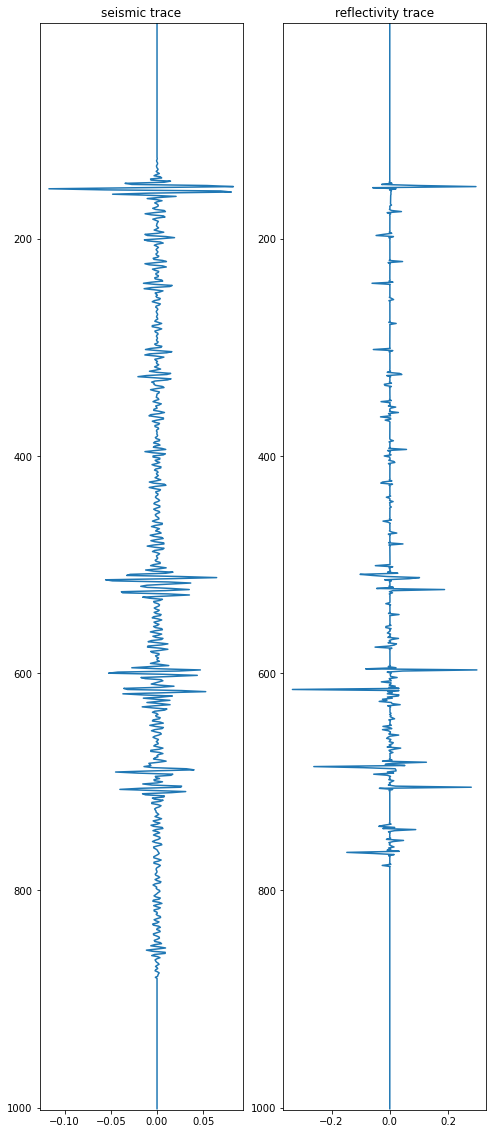

In [82]:
plt.figure(figsize=(8, 20))
ax = plt.subplot(121, title='seismic trace')
ax.plot(s_full_range, np.arange(1, s_full_range.shape[0]+1))
ax.set_ylim(s_full_range.shape[0] + 1, 1)
ax = plt.subplot(122, title='reflectivity trace')
ax.plot(r_full_range, np.arange(1, r_full_range.shape[0]+1))
ax.set_ylim(r_full_range.shape[0] + 1, 1)

It is seen that the reflectivity trace is likily artificial, as there are large zones of zero values. The seismic trace is modelled with noise and some other discrepeancies between seismic and reflectivity, e.g. compare the seismic signal with the reflectivity in range 725 to 800.

### Set some basic parameters of the wavelet and extraction.
All parameters are reference in samples. Seismic and reflectivity samples with the same index are assumed to be colocated. This also implies that the depth to time conversion for the reflectivity series is accurate, though working with the tiepoint parameter allows too extract correctly placed wavelets from reflectivity trace that have a known shift to the seismic trace.

If you do not know wavelet lenght or causality, make the wavelet longer with the midpoint in the center and find more precise parameters by iteration. It may be necesary to apply stronger regularization for longer wavelets.

If there is an unknown bulk-shift between reflectivity trace and seismic trace, extract an wavelet with a very long window, realign the data or reset the tiepoint parameter, and repeat the extraction with tighter parameters.

The extraction interval is referenced to the seismic trace. 

In [83]:
length = 50
tiepoint = 25 # t=o sample of the wavelet
first_sample = 150
first_sample = first_sample - 1 #because interpreters start counting from 1
last_sample = 725

### Extract the correct lenghts of reflectivity and seismic data
Note the reflectivity data used will extend beyond the seismic data boundaries. It is good practice to check if all reflectivity data used is valid and of good quality.

In [84]:
first_sample_r = first_sample - length + 1 + tiepoint
last_sample_r = last_sample + tiepoint

s_analysis_range = s_full_range[first_sample:last_sample]
r_analysis_range = r_full_range[first_sample_r:last_sample_r]

(751.0, 126.0)

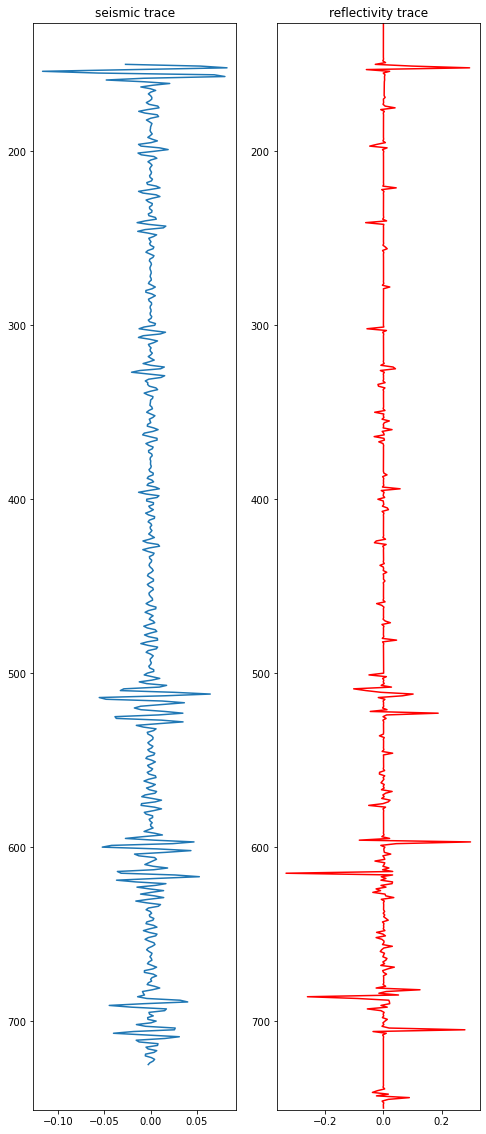

In [85]:
plt.figure(figsize=(8, 20))
ax = plt.subplot(121, title='seismic trace')
ax.plot(s_analysis_range, np.arange(first_sample + 1, last_sample + 1, 1))
ax.set_ylim(last_sample_r + 1, first_sample_r + 1)
ax = plt.subplot(122, title='reflectivity trace')
ax.plot(r_analysis_range, np.arange(first_sample_r + 1, last_sample_r + 1, 1), 'r')
ax.set_ylim(last_sample_r + 1, first_sample_r + 1)

### Invert for a wavelet w/o any regularization
The forward model is 1D convolution, which is written as matrix vector multiplication. This is than inverted using a least squares error minimazation.

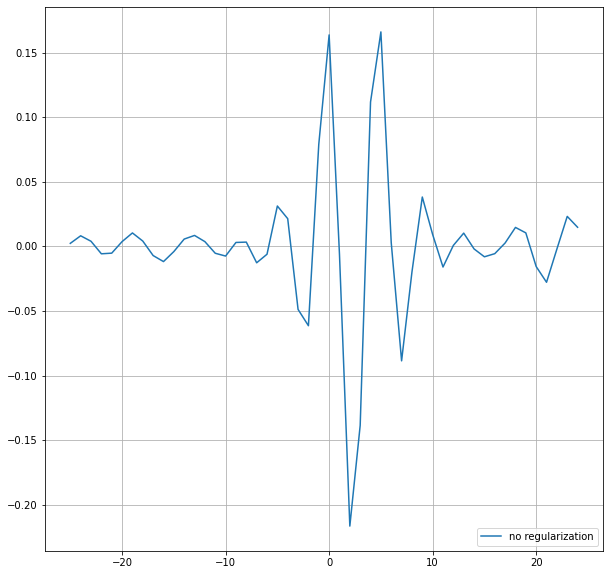

In [86]:
#Organize the reflectivity matrix 
r_analysis_matrix = la.toeplitz(r_analysis_range)
r_analysis_matrix = r_analysis_matrix[length-1:, :length]
#Invert for the wavelet
W = np.linalg.lstsq(r_analysis_matrix, s_analysis_range, rcond=None)
w = W[0]

plt.figure(figsize=[10,10])
plt.plot(np.arange(w.shape[0]) - tiepoint, w, label='no regularization')
plt.grid()
plt.legend(loc='lower right')

The wavelet is faily spiky. Outboard of the second positive sidelobe looks increasingly that the S/N ratio may be lower for thos part of the wavelet (e.g. the pick-up in amplitudes around samples 45 to 50). To avoid fitting noise the wavelet can be made shorter. Also the wavelet is not centered in the extraction window. This is an indication that the reflectivity trace and seismic trace are not entirely tied. To extract a wavelet that is centered the tiepoint can be moved, which is equivalent to adjusting the well log to seismic tie.

As an experiment, graph how the wavelet lenght affects the prediction error.

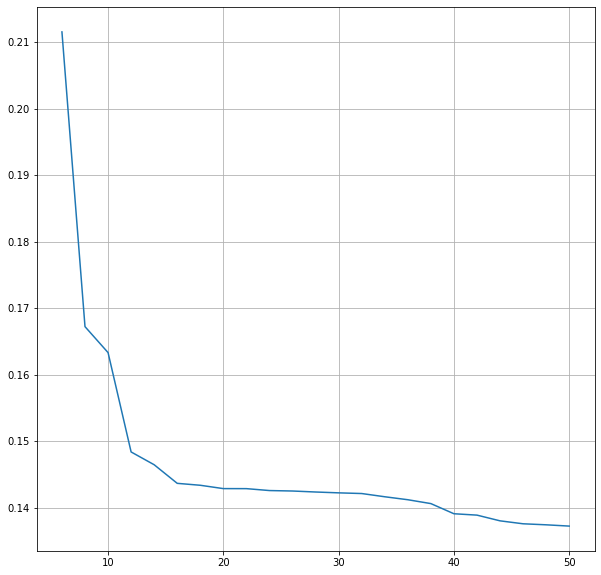

In [87]:
lengths = np.arange(6,51,2)
errors =  np.zeros_like(lengths, dtype='float')
for n, l in enumerate(lengths):
    tiepoint_l = int((l - 4)/2)
    first_sample_r_l = first_sample - l + 1 + tiepoint_l
    last_sample_r_l = last_sample + tiepoint_l
    r_analysis_range_l = r_full_range[first_sample_r_l:last_sample_r_l]

    #Organize the reflectivity matrix 
    r_analysis_matrix_l = la.toeplitz(r_analysis_range_l)
    r_analysis_matrix_l = r_analysis_matrix_l[l-1:, :l]
    
    W_l = np.linalg.lstsq(r_analysis_matrix_l, s_analysis_range, rcond=None)
    w_l = W_l[0]
    errors[n] = la.norm(np.convolve(r_analysis_range_l, w_l, mode='valid') - s_analysis_range)

plt.figure(figsize=[10,10])
plt.plot(lengths, errors)
plt.grid(which='both')
ax.set_title='prediction error against the number of wavelet coefficients'

It is seen that above 16 wavelet coefficients there is little improvement in prediction error. There is marked improvement in prediction error at 40 coefficients. Possible the model includes some short period multiples and fitting these in the wavelet reponse might give a response like this(?). Reset the number of prediction coefficients to something a bit higher as 16.

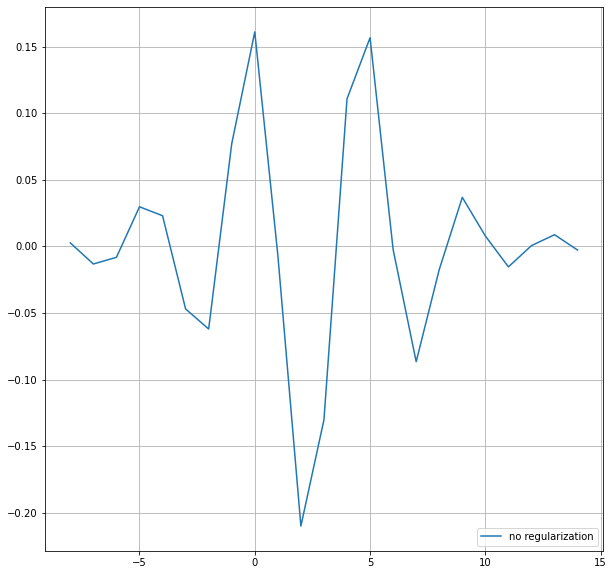

In [89]:
length = 23
tiepoint = 8 # t=o sample of the wavelet

first_sample_r = first_sample - length + 1 + tiepoint
last_sample_r = last_sample + tiepoint
r_analysis_range = r_full_range[first_sample_r:last_sample_r]

#Organize the reflectivity matrix 
r_analysis_matrix = la.toeplitz(r_analysis_range)
r_analysis_matrix = r_analysis_matrix[length-1:, :length]
#Invert for the wavelet
W = np.linalg.lstsq(r_analysis_matrix, s_analysis_range, rcond=None)
w = W[0]

plt.figure(figsize=[10,10])
plt.plot(np.arange(w.shape[0]) - tiepoint, w, label='no regularization')
plt.grid()
plt.legend(loc='lower right')

This has improved the look of the wavelet as the middle of the wavelet is now centered (though the center is not at t=0!). To check display the synthetic created with this wavelet and compare it with the original signal.

(734.0, 136.0)

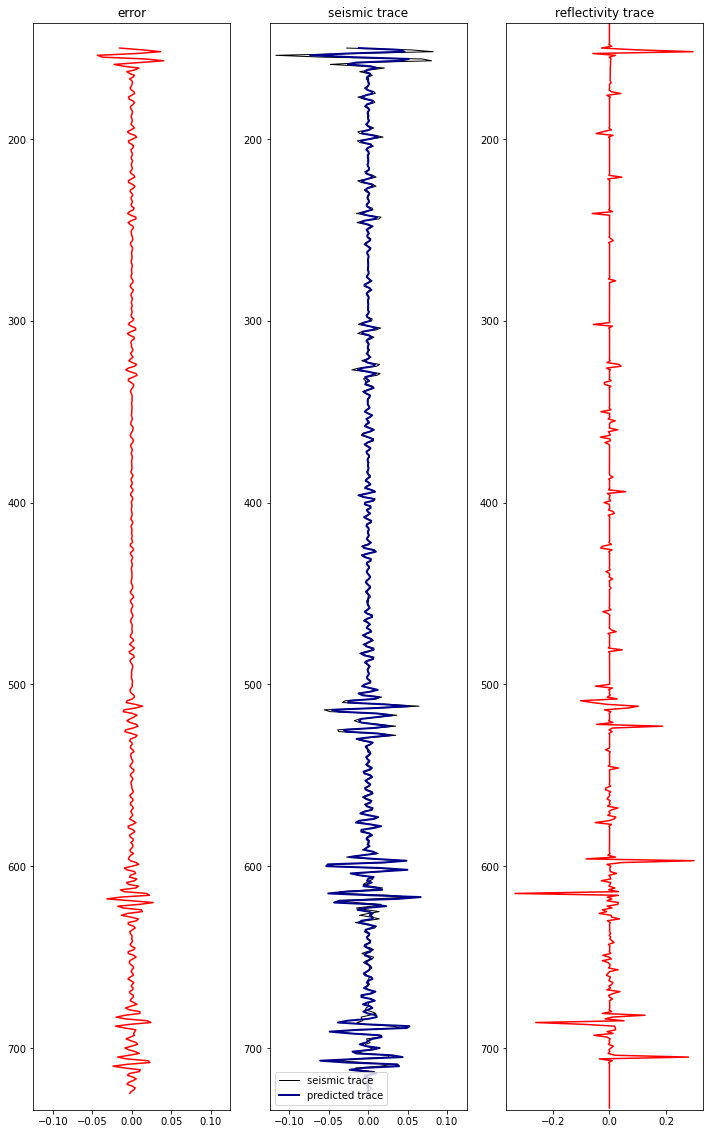

In [90]:
seismic_pred_wavelet =  np.convolve(r_analysis_range, w, mode='valid')

plt.figure(figsize=(12, 20))
ax = plt.subplot(132, title='seismic trace')
ax.set_xlim(-0.125, 0.125)
ax.plot(s_analysis_range, np.arange(first_sample + 1, last_sample + 1, 1), 'k', linewidth=1 ,label='seismic trace')
ax.plot(seismic_pred_wavelet, np.arange(first_sample + 1, last_sample + 1, 1), 'darkblue', linewidth=2 ,label='predicted trace')
ax.set_ylim(last_sample_r + 1, first_sample_r + 1)
ax.legend(loc='lower left')
ax = plt.subplot(133, title='reflectivity trace')
ax.plot(r_analysis_range, np.arange(first_sample_r + 1, last_sample_r + 1, 1), 'r')
ax.set_ylim(last_sample_r + 1, first_sample_r + 1)
ax = plt.subplot(131, title='error')
ax.set_xlim(-0.125, 0.125)
ax.plot(s_analysis_range - seismic_pred_wavelet, np.arange(first_sample + 1, last_sample + 1, 1), 'r')
ax.set_ylim(last_sample_r + 1, first_sample_r + 1)

And let's have a look at a zoom.

(550.0, 700.0)

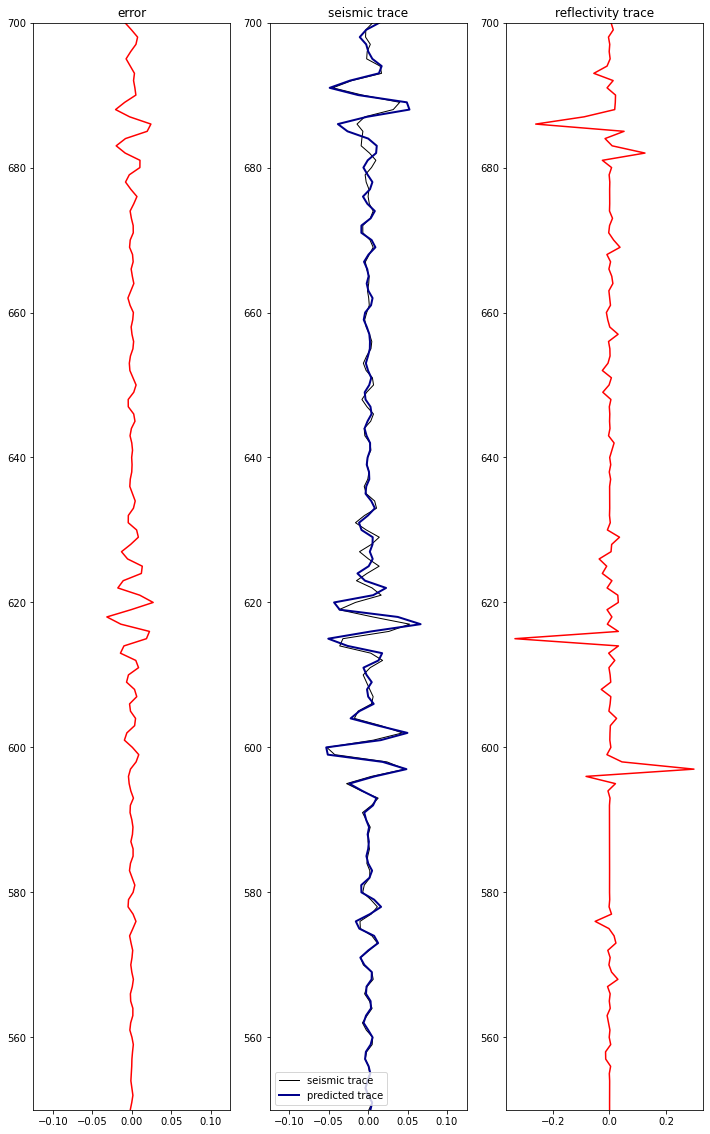

In [91]:
plt.figure(figsize=(12, 20))
ax = plt.subplot(132, title='seismic trace')
ax.set_xlim(-0.125, 0.125)
ax.plot(s_analysis_range, np.arange(first_sample + 1, last_sample + 1, 1), 'k', linewidth = 1 ,label='seismic trace')
ax.plot(seismic_pred_wavelet, np.arange(first_sample + 1, last_sample + 1, 1), 'darkblue', linewidth = 2 ,label='predicted trace')
ax.set_ylim(550, 700)
ax.legend(loc='lower left')
ax = plt.subplot(133, title='reflectivity trace')
ax.plot(r_analysis_range, np.arange(first_sample_r + 1, last_sample_r + 1, 1), 'r')
ax.set_ylim(550, 700)
ax = plt.subplot(131, title='error')
ax.set_xlim(-0.125, 0.125)
ax.plot(s_analysis_range - seismic_pred_wavelet, np.arange(first_sample + 1, last_sample + 1, 1), 'r')
ax.set_ylim(550, 700)

### Adding a simple L2 regularization (aka ridge-regression, aka (a special case of) Tikhonov regularization)
Inversion is stabilized by defining an penalty on the magnitude of the wavelet coefficients. This prevents outliers due to noise. I implement this workflow here by extending the reflectivity matrix.


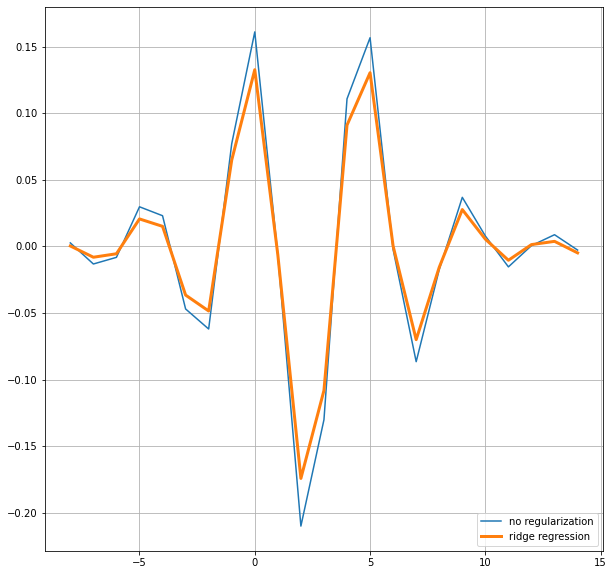

In [92]:
penalty_factor = 0.35 #usually denoted lambda in literature, determines the amount of regularization

#Extend the model equations to include the regularization, alternatively the ridge regression in sklearn can be used
r_analysis_matrix_reg = np.concatenate((r_analysis_matrix, np.diag(penalty_factor * np.ones(length))))
s_analysis_range_reg = np.concatenate((s_analysis_range, np.zeros(length)))
#Invert
W_reg = np.linalg.lstsq(r_analysis_matrix_reg, s_analysis_range_reg, rcond=None)
w_reg = W_reg[0]

plt.figure(figsize=[10,10])
plt.plot(np.arange(w.shape[0]) - tiepoint, w, label='no regularization')
plt.plot(np.arange(w.shape[0]) - tiepoint, w_reg, label='ridge regression', linewidth = 3)
plt.grid()
plt.legend(loc='lower right')

In [93]:
error_w = la.norm(np.convolve(r_analysis_range, w, mode='valid') - s_analysis_range)
error_w_reg = la.norm(np.convolve(r_analysis_range, w_reg, mode='valid') - s_analysis_range)

print("Prediction error 'no regularization' = ", error_w )
print("Prediction error 'ridge regression' = ", error_w_reg )

Prediction error 'no regularization' =  0.14267173409461975
Prediction error 'ridge regression' =  0.15156130355536224


As expected adding regularization increases the prediction error. 

### Adding more realistic L2 regularization
In the example the main effect is a reduction in amplitude, though normally one expect a 'regularized' wavelet to be smoother. Knowning the seismic experiment we expect that with proper acquisition and processing most of the seismic energy is centered in the middle of the wavelet. It makes sense to adjust the regularization to incorporate that expectation. That can be done in many way, here a linear trend as funtion of the distance to the midpoint is applied to the regularization term. Of course other functions can be defined, some of which might be better.

Text(0.5, 1.0, 'regularization factor on each wavelet coefficient')

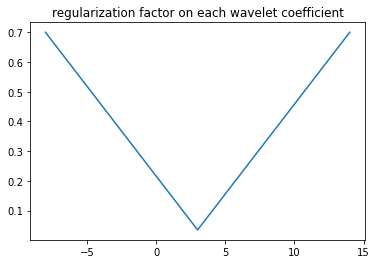

In [94]:
#Construct the penalty function
penalty_factor_edge = 0.7
penalty_factor_middle = 0.035
pen_left = np.linspace(penalty_factor_edge, penalty_factor_middle, int((length+1)/2))
pen_right = np.flipud(pen_left[:length-pen_left.shape[0]])
pen =  np.concatenate((pen_left, pen_right))
plt.plot(np.arange(w.shape[0]) - tiepoint, pen)
plt.title('regularization factor on each wavelet coefficient')

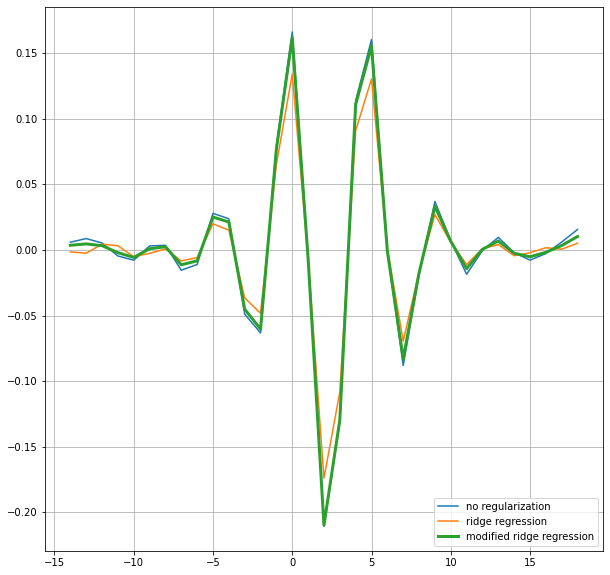

In [100]:
#Extend the model equations to include the regularization
r_analysis_matrix_reg2 = np.concatenate((r_analysis_matrix, np.diag(pen)))
s_analysis_range_reg2 = np.concatenate((s_analysis_range, np.zeros(length)))
#Invert
W_reg2 = np.linalg.lstsq(r_analysis_matrix_reg2, s_analysis_range_reg2, rcond=None)
w_reg2 = W_reg2[0]

plt.figure(figsize=[10,10])
plt.plot(np.arange(w.shape[0]) - tiepoint, w, label='no regularization')
plt.plot(np.arange(w.shape[0]) - tiepoint,  w_reg, label='ridge regression')
plt.plot(np.arange(w.shape[0]) - tiepoint, w_reg2, label='modified ridge regression', linewidth = 3)
plt.grid()
plt.legend(loc='lower right')

In [99]:
error_w_reg2 = la.norm(np.convolve(r_analysis_range, w_reg2, mode='valid') - s_analysis_range)

print("Prediction error 'no regularization' = ", error_w )
print("Prediction error 'ridge regression' = ", error_w_reg )
print("Prediction error 'modified ridge regression' = ", error_w_reg2 )

Prediction error 'no regularization' =  0.14162766933441162
Prediction error 'ridge regression' =  0.15133553278565384
Prediction error 'modified ridge regression' =  0.14197129721093688


Now the center of the wavelet is not so much affected by regularization, while the sides are similar to the sides of the wavelet predicted with ridge regression. The prediction error of modified ridge regression is much much better than that of ridge regression and only slightly less as with unregularized regression. 

However note that prediction error is not a quantity that we can use to determine which wavelet is better for other processes such as modelling or inversion. To do that and set the regularization parameters correctly some workflows from data science could be used, for example cross-validation, but that is beyond this notebook.

### Zeroing the wavelet terminations
The previous example shows how we can suppress noise at either side of the wavelet while not affecting the central lobes to much. Also, based on physics, it is expected (wished for) that the wavelet will smoothly taper out to zero when sufficiently far away from the central lobe (under the condition that the wavelet extraction window is long enough of course).

Often this is achieved by tapering the wavelet after the wavelet is predicted. But this behavior can also be achieved within the wavelet prediction by applying extra regularization terms. A few methods to achieve that will be implemented.

Start by making the predicted wavelet slightly longer and redoing some of the previous steps with the longer wavelet.

In [97]:
length = 33
tiepoint = 14 # t=o sample of the wavelet

first_sample_r = first_sample - length + 1 + tiepoint
last_sample_r = last_sample + tiepoint

s_analysis_range = s_full_range[first_sample:last_sample]
r_analysis_range = r_full_range[first_sample_r:last_sample_r]

#Organize the reflectivity matrix 
r_analysis_matrix = la.toeplitz(r_analysis_range)
r_analysis_matrix = r_analysis_matrix[length-1:, :length]
#Invert for the wavelet
W = np.linalg.lstsq(r_analysis_matrix, s_analysis_range, rcond=None)
w = W[0]

penalty_factor = 0.35 #usually denoted lambda in literature, determines the amount of regularization

#Extend the model equations to include the regularization
r_analysis_matrix_reg = np.concatenate((r_analysis_matrix, np.diag(penalty_factor * np.ones(length))))
s_analysis_range_reg = np.concatenate((s_analysis_range, np.zeros(length)))
#Invert
W_reg = np.linalg.lstsq(r_analysis_matrix_reg, s_analysis_range_reg, rcond=None)
w_reg = W_reg[0]

#Construct the penalty function
penalty_factor_edge = 0.5
penalty_factor_middle = 0.025
pen_left = np.linspace(penalty_factor_edge, penalty_factor_middle, int((length+1)/2))
pen_right = np.flipud(pen_left[:length-pen_left.shape[0]])
pen =  np.concatenate((pen_left, pen_right))

#Extend the model equations to include the regularization
r_analysis_matrix_reg2 = np.concatenate((r_analysis_matrix, np.diag(pen)))
s_analysis_range_reg2 = np.concatenate((s_analysis_range, np.zeros(length)))
#Invert
W_reg2 = np.linalg.lstsq(r_analysis_matrix_reg2, s_analysis_range_reg2, rcond=None)
w_reg2 = W_reg2[0]

error_w = la.norm(np.convolve(r_analysis_range, w, mode='valid') - s_analysis_range)
error_w_reg = la.norm(np.convolve(r_analysis_range, w_reg, mode='valid') - s_analysis_range)
error_w_reg2 = la.norm(np.convolve(r_analysis_range, w_reg2, mode='valid') - s_analysis_range)

print("Prediction error 'no regularization' = ", error_w )
print("Prediction error 'ridge regression' = ", error_w_reg )
print("Prediction error 'modified ridge regression' = ", error_w_reg2 )

Prediction error 'no regularization' =  0.14162766933441162
Prediction error 'ridge regression' =  0.15133553278565384
Prediction error 'modified ridge regression' =  0.14197129721093688


Note that the wavelet was made 10 coefficients longer and that the prediction error only decreases slightly. 

### Method 1
Now apply rextra rugluarization to taper the wavelet to zero. The first method to explore is blowing up the variable regularization towards the edges of the wavelet. 

Text(0.5, 1.0, 'regularization coefficients')

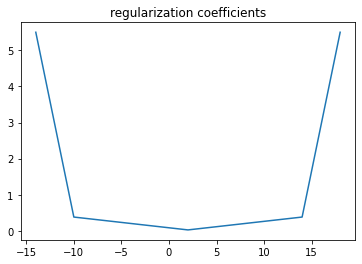

In [101]:
#Construct the penalty function
#Construct the penalty function
penalty_factor_edge = 0.5
penalty_factor_middle = 0.025
pen_left = np.linspace(penalty_factor_edge, penalty_factor_middle, int((length+1)/2))
pen_right = np.flipud(pen_left[:length-pen_left.shape[0]])
pen =  np.concatenate((pen_left, pen_right))

penalty_factor_edge =  5
taper_lenght = 4
pen_left = np.linspace(penalty_factor_edge, 0, taper_lenght+1)
pen_right = np.flipud(pen_left[:length-pen_left.shape[0]])
pen[:taper_lenght] = pen[:taper_lenght] + pen_left[:taper_lenght]
pen[-taper_lenght:] = pen[-taper_lenght:] + pen_right[-taper_lenght:]

plt.plot(np.arange(w.shape[0]) - tiepoint, pen)
plt.title('regularization coefficients')

Prediction error 'no regularization' =  0.14162766933441162
Prediction error 'ridge regression' =  0.15133553278565384
Prediction error 'modified ridge regression' =  0.14197129721093688
Prediction error 'tapered modified ridge regression' =  0.1426999809199849


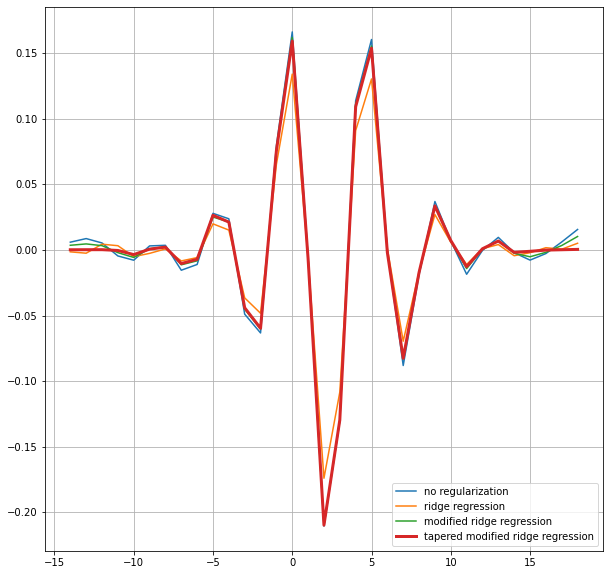

In [107]:
#Extend the model equations to include the regularization
r_analysis_matrix_reg3 = np.concatenate((r_analysis_matrix, np.diag(pen)))
s_analysis_range_reg3 = np.concatenate((s_analysis_range, np.zeros(length)))
#Invert
W_reg3 = np.linalg.lstsq(r_analysis_matrix_reg3, s_analysis_range_reg, rcond=None)
w_reg3 = W_reg3[0]

plt.figure(figsize=[10,10])
plt.plot(np.arange(w.shape[0]) - tiepoint, w, label='no regularization')
plt.plot(np.arange(w.shape[0]) - tiepoint, w_reg, label='ridge regression')
plt.plot(np.arange(w.shape[0]) - tiepoint, w_reg2, label='modified ridge regression')
plt.plot(np.arange(w.shape[0]) - tiepoint, w_reg3, label='tapered modified ridge regression', linewidth = 3)
plt.grid()
plt.legend(loc='lower right')

error_w_reg3 = la.norm(np.convolve(r_analysis_range, w_reg3, mode='valid') - s_analysis_range)

print("Prediction error 'no regularization' = ", error_w )
print("Prediction error 'ridge regression' = ", error_w_reg )
print("Prediction error 'modified ridge regression' = ", error_w_reg2 )
print("Prediction error 'tapered modified ridge regression' = ", error_w_reg3 )

When the previous method is applied and experimenting with different weighting and taper lengths, it is seen that with enough regularization the wavelet edges limit to zero. Also it is seen that this type of regularization hardly affects the prediction error. But artifacts can be introduced easily. Possible this can partially be resolved by chosing a smoother definition of the outer regularization. 

Text(0.5, 1.0, 'regularization coefficients')

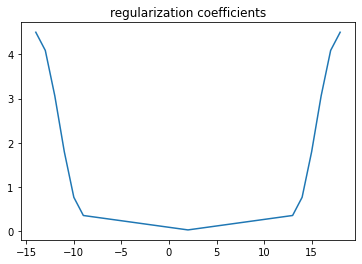

In [108]:
#Construct the penalty function
penalty_factor_edge = 0.5
penalty_factor_middle = 0.025
pen_left = np.linspace(penalty_factor_edge, penalty_factor_middle, int((length+1)/2))
pen_right = np.flipud(pen_left[:length-pen_left.shape[0]])
pen =  np.concatenate((pen_left, pen_right))

penalty_factor_edge =  4
taper_lenght = 5
pen_left = np.pi/2 * np.linspace(0, 1, taper_lenght+1)
pen_left = penalty_factor_edge * np.square(np.cos(pen_left))
pen_right = np.flipud(pen_left[:length-pen_left.shape[0]])
pen[:taper_lenght] = pen[:taper_lenght] + pen_left[:taper_lenght]
pen[-taper_lenght:] = pen[-taper_lenght:] + pen_right[-taper_lenght:]

plt.plot(np.arange(w.shape[0]) - tiepoint, pen)
plt.title('regularization coefficients')

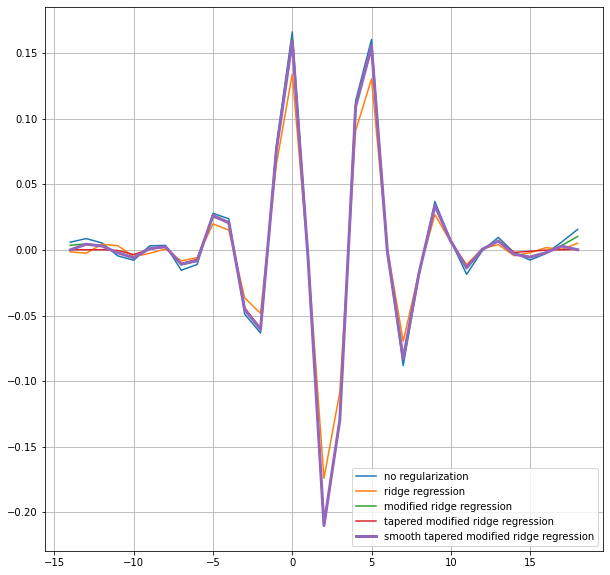

In [111]:
#Extend the model equations to include the regularization
r_analysis_matrix_reg4 = np.concatenate((r_analysis_matrix, np.diag(pen)))
s_analysis_range_reg4 = np.concatenate((s_analysis_range, np.zeros(length)))
#Invert
W_reg4 = np.linalg.lstsq(r_analysis_matrix_reg4, s_analysis_range_reg, rcond=None)
w_reg4 = W_reg4[0]

plt.figure(figsize=[10,10])
x = np.arange(w.shape[0]) - tiepoint
plt.plot(x, w, label='no regularization')
plt.plot(x, w_reg, label='ridge regression')
plt.plot(x, w_reg2, label='modified ridge regression')
plt.plot(x, w_reg3, label='tapered modified ridge regression')
plt.plot(x, w_reg4, label='smooth tapered modified ridge regression', linewidth = 3)
plt.grid()
plt.legend(loc='lower right')

Though the difference is not really visible in this example, the latter gives better results on physical wavelets.

### Method2
Now a 'more advanced' method will be applied, forcing a number of differential approximated by finite difference operators to zero at the edge points. E.i. a number of differentials must exist and go to zero at the wavelets edge, i.e. the wavelet is zero and 'smooth' at its edge.

First construct a modified ridge regression, with a very strong regularization on the first and last coeffienct to enforce the near zero value for the first and last coefficient. Then add conditions for a set of finite difference operators to enforce smooth behaviour near the edges.

Text(0.5, 1.0, 'regularization coefficients')

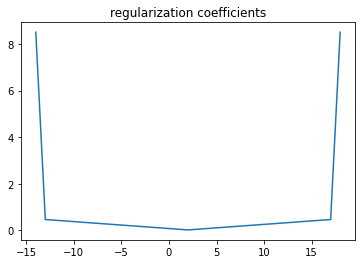

In [112]:
penalty_factor_edge = 0.5
penalty_factor_middle = 0.025
pen_left = np.linspace(penalty_factor_edge, penalty_factor_middle, int((length+1)/2))
pen_right = np.flipud(pen_left[:length-pen_left.shape[0]])
pen =  np.concatenate((pen_left, pen_right))

add_penalty_at_edge = 8
pen_left = np.linspace(penalty_factor_edge, penalty_factor_middle, int((length+1)/2))
pen_right = np.flipud(pen_left[:length-pen_left.shape[0]])
pen =  np.concatenate((pen_left, pen_right))
pen[[0,-1]] = pen[[0,-1]] + add_penalty_at_edge

plt.plot(x, pen)
plt.title('regularization coefficients')

Prediction error 'no regularization' =  0.14162766933441162
Prediction error 'ridge regression' =  0.15133553278565384
Prediction error 'modified ridge regression' =  0.14197129721093688
Prediction error 'tapered modified ridge regression' =  0.1426999809199849
Prediction error 'tapered method 2 modified ridge regression' =  0.14269744985853208


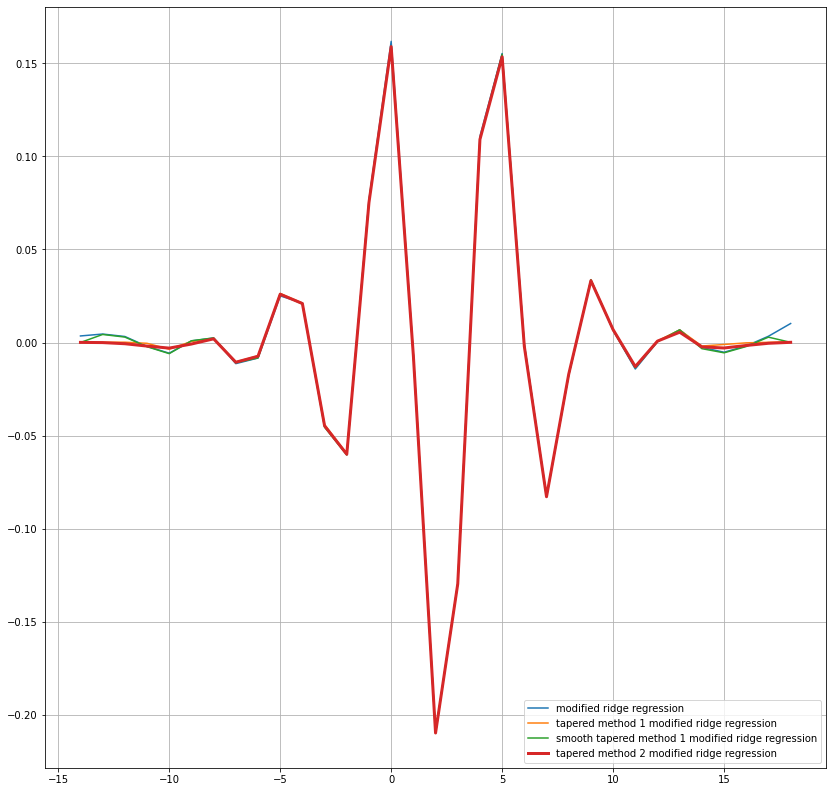

In [114]:
first_der_penalty = 4
second_der_penalty = 2
third_der_penalty = 1
fourth_der_penalty = 0.5

der_regularization = np.zeros([8,length])

der_regularization[0, :3] = first_der_penalty * np.array([-3/2, 2, -1/2]) #first derivative forward
der_regularization[1,:4] = second_der_penalty * np.array([2, -5, 4, -1]) #second derivative forward
der_regularization[2, :5] = third_der_penalty * np.array([-5/2, 9, -12, 7, -3/2]) #etc
der_regularization[3, :6] = fourth_der_penalty * np.array([3, -14, 26, -24, 11, -2]) #etc

der_regularization[4,:] = -1 * np.flipud(der_regularization[0,:]) #first derivative backward
der_regularization[5,:] = np.flipud(der_regularization[1,:]) #etc
der_regularization[6,:] = -1 * np.flipud(der_regularization[2,:]) #etc
der_regularization[7, :] = np.flipud(der_regularization[3, :]) #etc

r_analysis_matrix_reg5 = np.concatenate((r_analysis_matrix, np.diag(pen), der_regularization))
s_analysis_range_reg5 = np.concatenate((s_analysis_range, np.zeros(length), np.zeros(8)))

#Invert
W_reg5 = np.linalg.lstsq(r_analysis_matrix_reg5, s_analysis_range_reg5, rcond=None)
w_reg5 = W_reg5[0]

plt.figure(figsize=[14,14])
# plt.plot(w, label='no regularization')
# plt.plot(w_reg, label='ridge regression')
plt.plot(x, w_reg2, label='modified ridge regression')
plt.plot(x, w_reg3, label='tapered method 1 modified ridge regression')
plt.plot(x, w_reg4, label='smooth tapered method 1 modified ridge regression')
plt.plot(x, w_reg5, label='tapered method 2 modified ridge regression', linewidth = 3)
plt.grid()
plt.legend(loc='lower right')

error_w_reg5 = la.norm(np.convolve(r_analysis_range, w_reg5, mode='valid') - s_analysis_range)

print("Prediction error 'no regularization' = ", error_w )
print("Prediction error 'ridge regression' = ", error_w_reg )
print("Prediction error 'modified ridge regression' = ", error_w_reg2 )
print("Prediction error 'tapered modified ridge regression' = ", error_w_reg3 )
print("Prediction error 'tapered method 2 modified ridge regression' = ", error_w_reg5 )

This solution is faily nice, as it honors more of the data, while going to zero smoothly. However sometimes some wobbles may be introduced relating to the operator length. One can easily think of some approaches too minimize these numerical effects, however the question is if this is worth the effort. When using the wavelet in application such as modeling or inversion, this artifact will be of minor importance compare to other uncertainties.

### An completely other approach
Typically we like our wavelets compact, i.e. with most energy in the center, this is what is strived for in processing. If there is enough non-uniqueness in the prediction, one way to extract more compact wavelets from the prediction is to calculate the second moment of the wavelet envelop and including this as penalty term. Including this in the penalty term requires alternative optimization methods, as the problem is not longer linear and there might be more than one minimum in the objective funtion (I did not analyse this in detail).

First a test is done using the basinhopper optimization method and no additional penalty. 

In [115]:
def obj(w): 
    t1 = s_analysis_range - r_analysis_matrix.dot(w)
    return la.norm(t1)  

In [116]:
res =  basinhopping(obj, np.ones_like(w))

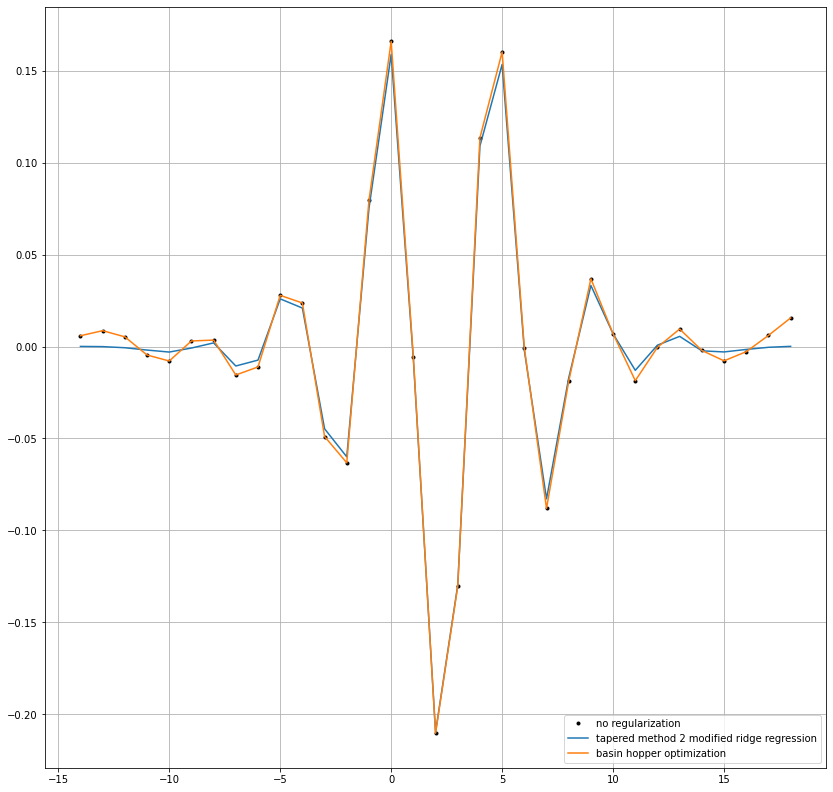

In [117]:
plt.figure(figsize=[14,14])
plt.plot(x, w,'k.', label='no regularization',)
plt.plot(x, w_reg5, label='tapered method 2 modified ridge regression')
plt.plot(x, res.x, label='basin hopper optimization')
plt.grid()
plt.legend(loc='lower right')

It is seen that the basinhopper optimization without any regularization (the only penalty is to difference of physical model and the signal) gives the same result as unconstrained linear least squares inversion - as expected.

Now a objective function is defined that includes a penalty for the second moment of the wavelet as regularization and the optimazation is ran again.

In [118]:
penalty_factor = 0.1

def obj4(w):
    t1 = s_analysis_range - r_analysis_matrix.dot(w)
    index = np.arange(w.shape[0])
    t2 = abs(hilbert(w))
    t2 = t2 / np.sum(t2)
    t3 = t2 * index
    t4 = t3 * index
    return la.norm(t1) +  penalty_factor * np.sqrt(np.sum(t4) - np.sum(t3) ** 2)

Prediction error 'no regularization' =  0.14162766933441162
Prediction error 'ridge regression' =  0.15133553278565384
Prediction error 'tapered modified ridge regression' =  0.1426999809199849
Prediction error 'basin hopper with moment penelaty' =  0.18207455223961333


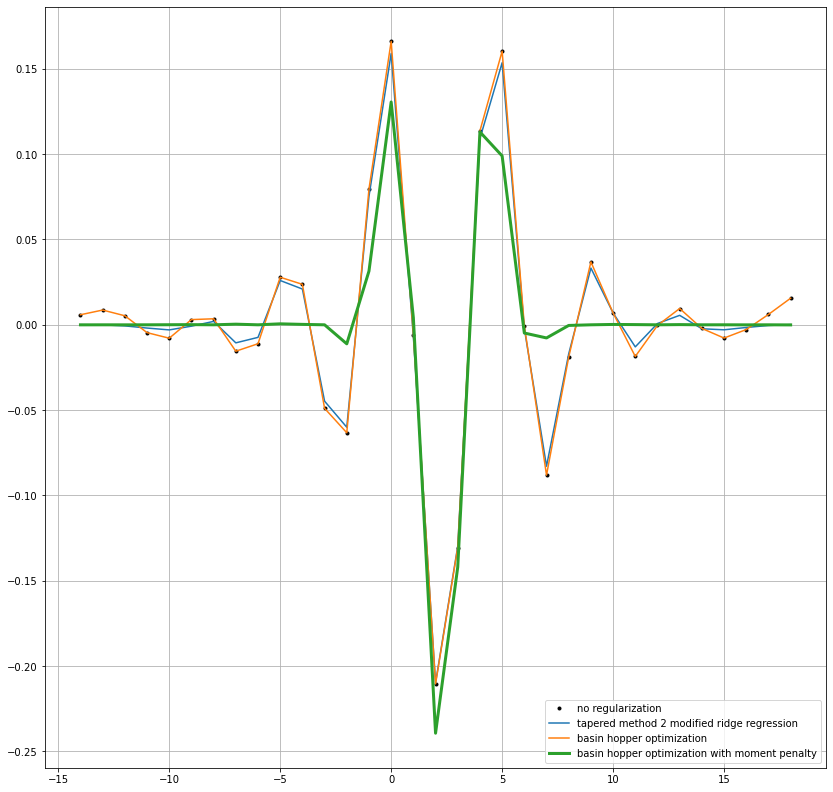

In [119]:
res4 =  basinhopping(obj4, np.ones_like(w) )

plt.figure(figsize=[14,14])
plt.plot(x, w,'k.', label='no regularization',)
plt.plot(x, w_reg5, label='tapered method 2 modified ridge regression')
plt.plot(x, res.x, label='basin hopper optimization')
plt.plot(x, res4.x, label='basin hopper optimization with moment penalty', linewidth=3)
plt.grid()
plt.legend(loc='lower right')

error_w_res4 = la.norm(np.convolve(r_analysis_range, res4.x, mode='valid') - s_analysis_range)

print("Prediction error 'no regularization' = ", error_w )
print("Prediction error 'ridge regression' = ", error_w_reg )
print("Prediction error 'tapered modified ridge regression' = ", error_w_reg3 )
print("Prediction error 'basin hopper with moment penalty' = ", error_w_res4 )

So this works, and in this example the result is regularized to strong, with much of the wavelet near zero and the prediction error notably up. Do this again, but with the penatly term for the second moment set lower.

Prediction error 'no regularization' =  0.14162766933441162
Prediction error 'ridge regression' =  0.15133553278565384
Prediction error 'tapered modified ridge regression' =  0.1426999809199849
Prediction error 'basin hopper with moment penelaty' =  0.18207455223961333
Prediction error 'basin hopper with moment penelaty' =  0.14593026430519657


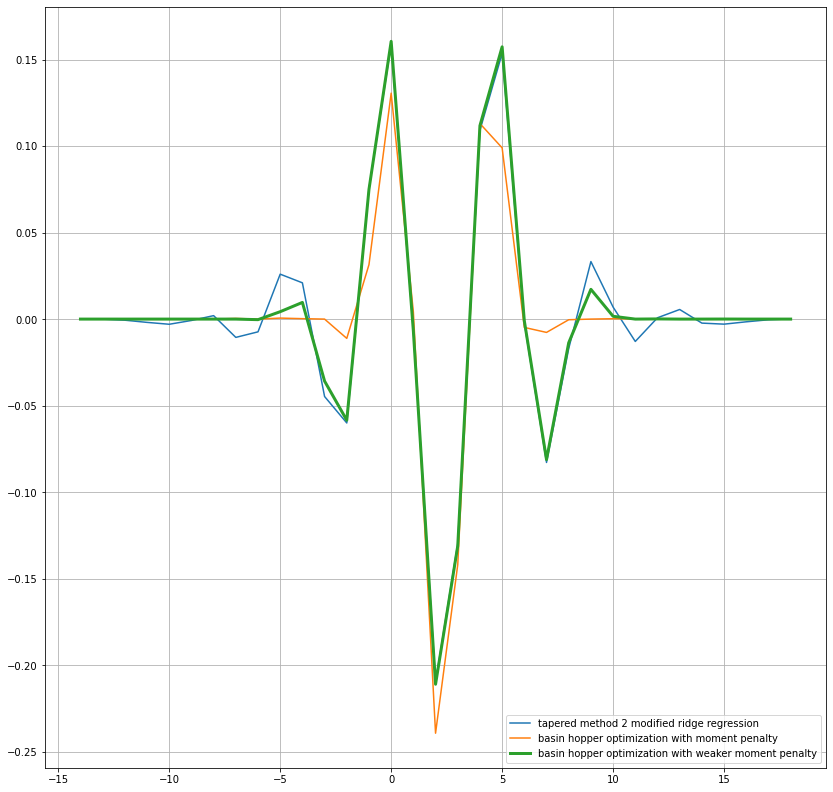

In [120]:
penalty_factor = 0.01

def obj5(w):
    t1 = s_analysis_range - r_analysis_matrix.dot(w)
    index = np.arange(w.shape[0])
    t2 = abs(hilbert(w))
    t2 = t2 / np.sum(t2)
    t3 = t2 * index
    t4 = t3 * index
    return la.norm(t1) +  penalty_factor * np.sqrt(np.sum(t4) - np.sum(t3) ** 2)

res5 =  basinhopping(obj5, np.ones_like(w) )

plt.figure(figsize=[14,14])
plt.plot(x, w_reg5, label='tapered method 2 modified ridge regression')
plt.plot(x, res4.x, label='basin hopper optimization with moment penalty')
plt.plot(x, res5.x, label='basin hopper optimization with weaker moment penalty', linewidth=3)
plt.grid()
plt.legend(loc='lower right')

error_w_res5 = la.norm(np.convolve(r_analysis_range, res5.x, mode='valid') - s_analysis_range)

print("Prediction error 'no regularization' = ", error_w )
print("Prediction error 'ridge regression' = ", error_w_reg )
print("Prediction error 'tapered modified ridge regression' = ", error_w_reg3)
print("Prediction error 'basin hopper with moment penalty' = ", error_w_res4)
print("Prediction error 'basin hopper with weaker moment penalty' = ", error_w_res5)

That is better, though visually it looks still a (too) bit strong, however the prediction error is much better. Further testing of the hyperparameter penalty factor may reveal the best amount of regularization. Also this regularization term can be combined with the L2 term from ridge regularization.

Obviously the global optimization is quite slow relative to the previous least squares optimizations, so now check if the results can be replecated using a local optimization method.

With with a 'poor' initial guess.

Prediction error 'basin hopper with weaker moment penalty' =  0.14593026430519657
Prediction error 'conjugate gradient optimization with weaker moment penalty' =  0.14471269973161652
Penalty at solution for 'basin hopper with weaker moment penalty' =  0.174813990923163
Penalty at solution for 'conjugate gradient optimization with weaker moment penalty' =  0.1752679913448194


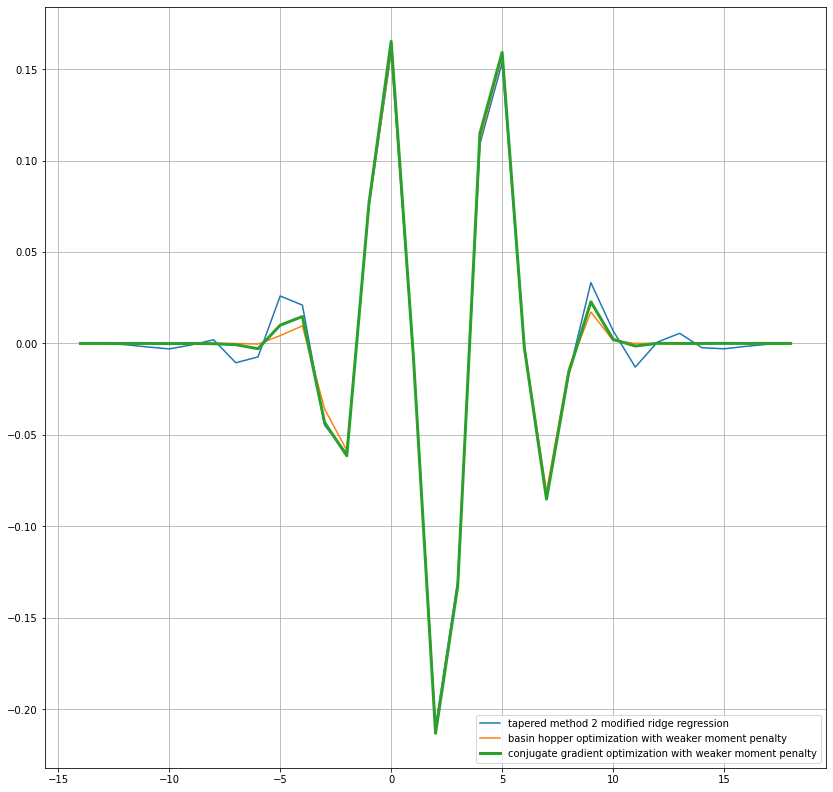

In [123]:
res6 =  minimize(obj5, np.ones_like(w), method='CG')

plt.figure(figsize=[14,14])
plt.plot(x, w_reg5, label='tapered method 2 modified ridge regression')
plt.plot(x, res5.x, label='basin hopper optimization with weaker moment penalty')
plt.plot(x, res6.x, label='conjugate gradient optimization with weaker moment penalty', linewidth=3)
plt.grid()
plt.legend(loc='lower right')

error_w_res6 = la.norm(np.convolve(r_analysis_range, res6.x, mode='valid') - s_analysis_range)

print("Prediction error 'basin hopper with weaker moment penalty' = ", error_w_res5)
print("Prediction error 'conjugate gradient optimization with weaker moment penalty' = ", error_w_res6)
print("Penalty at solution for 'basin hopper with weaker moment penalty' = ", obj5(res5.x))
print("Penalty at solution for 'conjugate gradient optimization with weaker moment penalty' = ", obj5(res6.x))

While the wavelets look very alike, there is a difference in result between the two methods, with the basinhopper global method showing a lower value in the objective function - hence the better minimalization of the penalty function,  though for practical purpose the results may of the same utility. Note that despite conjugate gradient having the lower prediction error, the basinhopper does better on optimizing the penalty function including regularization term.

As a test, run the local optimazation with a much better initial guess.

Prediction error 'basin hopper with weaker moment penalty' =  0.14593026430519657
Prediction error 'conjugate gradient optimization with weaker moment penalty' =  0.14471269973161652
Prediction error 'conjugate gradient optimization with closer initial guess' =  0.14448354232915836
Penalty at solution for 'basin hopper with weaker moment penalty' =  0.174813990923163
Penalty at solution for 'conjugate gradient optimization with weaker moment penalty' =  0.1752679913448194
Penalty at solution for 'conjugate gradient optimization with closer initial guess' =  0.17524032716153767


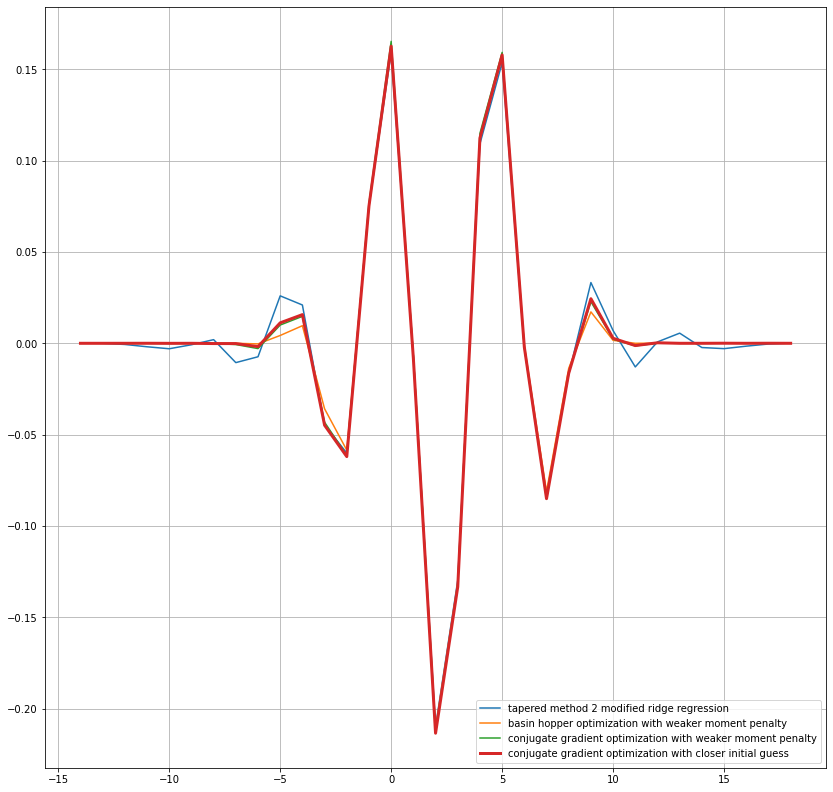

In [124]:
res7 =  minimize(obj5, w, method='CG')

plt.figure(figsize=[14,14])
plt.plot(x, w_reg5, label='tapered method 2 modified ridge regression')
plt.plot(x, res5.x, label='basin hopper optimization with weaker moment penalty')
plt.plot(x, res6.x, label='conjugate gradient optimization with weaker moment penalty')
plt.plot(x, res7.x, label='conjugate gradient optimization with closer initial guess', linewidth = 3)
plt.grid()
plt.legend(loc='lower right')

error_w_res7 = la.norm(np.convolve(r_analysis_range, res7.x, mode='valid') - s_analysis_range)

print("Prediction error 'basin hopper with weaker moment penalty' = ", error_w_res5)
print("Prediction error 'conjugate gradient optimization with weaker moment penalty' = ", error_w_res6)
print("Prediction error 'conjugate gradient optimization with closer initial guess' = ", error_w_res7)
print("Penalty at solution for 'basin hopper with weaker moment penalty' = ", obj5(res5.x))
print("Penalty at solution for 'conjugate gradient optimization with weaker moment penalty' = ", obj5(res6.x))
print("Penalty at solution for 'conjugate gradient optimization with closer initial guess' = ", obj5(res7.x))

The results are very similar as before, with a small improvement in the penatly value when using a closer initial guess, still the basinhopper global method shows a lower value in the objective function - hence the better result. So let's run basinhopper one more time with a slightly lower penalty factor.

In [128]:
penalty_factor = 0.0025
def obj6(w):
    t1 = s_analysis_range - r_analysis_matrix.dot(w)
    index = np.arange(w.shape[0])
    t2 = abs(hilbert(w))
    t2 = t2 / np.sum(t2)
    t3 = t2 * index
    t4 = t3 * index
    return la.norm(t1) +  penalty_factor * np.sqrt(np.sum(t4) - np.sum(t3) ** 2)

Prediction error 'no regularization' =  0.14162766933441162
Prediction error 'basin hopper with weakest moment penalty' =  0.1431091203547112


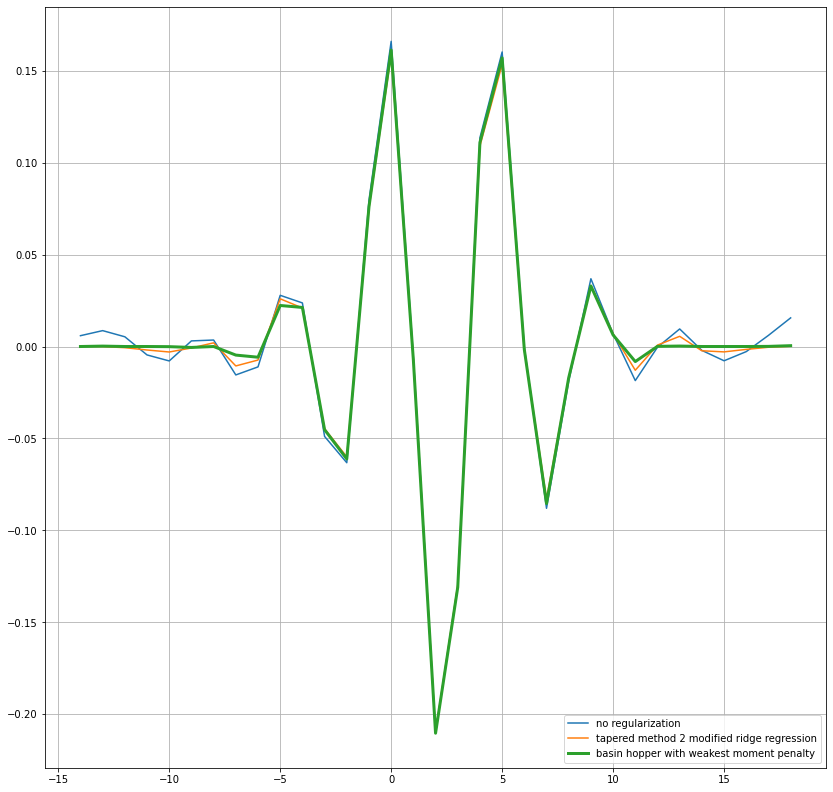

In [130]:
res8 = basinhopping(obj6, np.ones_like(w) )

plt.figure(figsize=[14,14])
plt.plot(x, w, label='no regularization')
plt.plot(x, w_reg5, label='tapered method 2 modified ridge regression')
plt.plot(x, res8.x, label='basin hopper with weakest moment penalty', linewidth = 3)
plt.grid()
plt.legend(loc='lower right')

error_w_res8 = la.norm(np.convolve(r_analysis_range, res8.x, mode='valid') - s_analysis_range)

print("Prediction error 'no regularization' = ", error_w )
print("Prediction error 'basin hopper with weakest moment penalty' = ", error_w_res8)

Note that the far sides of the wavelet have supressed amplitudes as they do not contribute much to improving the signal prediction. Similar to wavelet lenght, the optimal penalty factor is a hyperparameter to be optimized, ideally with a 'cross-validation' like approach. Also it is noted that using the second moment as regularization the solution changes drastically with the penalty factor applied. Possible using a first moment based penalty gives a different (better?) behavior.